In [ ]:
# import required libraries for dataframe and visualization

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# import required libraries for clustering
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import cosine_distances



In [ ]:
retail = pd.read_csv("retail sample grouped.csv", encoding= 'unicode_escape')


In [ ]:
df_null = round(100*(retail.isnull().sum())/len(retail), 2)
df_null

InvoiceNo      0.0
StockCode      0.0
Description    0.0
Quantity       0.0
InvoiceDate    0.0
UnitPrice      0.0
CustomerID     0.0
Country        0.0
dtype: float64

In [ ]:
# retail = retail.dropna()
retail.shape

(46694, 8)

In [ ]:
retail['CustomerID'] = retail['CustomerID'].astype(str)


In [ ]:
# New Attribute : Monetary

retail['Amount'] = retail['Quantity']*retail['UnitPrice']
rfm_m = retail.groupby('CustomerID')['Amount'].sum()
rfm_m = rfm_m.reset_index()
rfm_m.head()

,CustomerID,Amount
0,12346.0,0.00
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40


In [ ]:
# New Attribute : Frequency

rfm_f = retail.groupby('CustomerID')['InvoiceNo'].count()
rfm_f = rfm_f.reset_index()
rfm_f.columns = ['CustomerID', 'Frequency']
rfm_f.head()

,CustomerID,Frequency
0,12346.0,2
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17


In [ ]:
# Merging the two dfs

rfm = pd.merge(rfm_m, rfm_f, on='CustomerID', how='inner')
rfm.head()

,CustomerID,Amount,Frequency
0,12346.0,0.00,2
1,12347.0,4310.00,182
2,12348.0,1797.24,31
3,12349.0,1757.55,73
4,12350.0,334.40,17


In [ ]:
# New Attribute : Recency

# Convert to datetime to proper datatype

retail['InvoiceDate'] = pd.to_datetime(retail['InvoiceDate'],format='%d-%m-%Y %H:%M')

In [ ]:
max_date = max(retail['InvoiceDate'])
max_date

Timestamp('2011-12-09 12:50:00')

In [ ]:
# Compute the difference between max date and transaction date

retail['Diff'] = max_date - retail['InvoiceDate']
retail.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Amount,Diff
0,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,77183.60,325 days 02:49:00
1,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom,-77183.60,325 days 02:33:00
2,581180,23552,BICYCLE PUNCTURE REPAIR KIT,6,2011-12-07 15:52:00,2.08,12347.0,Iceland,12.48,1 days 20:58:00
3,562032,22727,ALARM CLOCK BAKELIKE RED,8,2011-08-02 08:48:00,3.75,12347.0,Iceland,30.00,129 days 04:02:00
4,562032,23146,TRIPLE HOOK ANTIQUE IVORY ROSE,4,2011-08-02 08:48:00,3.29,12347.0,Iceland,13.16,129 days 04:02:00


In [ ]:
# Compute last transaction date to get the recency of customers

rfm_p = retail.groupby('CustomerID')['Diff'].min()
rfm_p = rfm_p.reset_index()
rfm_p.head()

,CustomerID,Diff
0,12346.0,325 days 02:33:00
1,12347.0,1 days 20:58:00
2,12348.0,74 days 23:37:00
3,12349.0,18 days 02:59:00
4,12350.0,309 days 20:49:00


In [ ]:
# Extract number of days only

rfm_p['Diff'] = rfm_p['Diff'].dt.days
rfm_p.head()

,CustomerID,Diff
0,12346.0,325
1,12347.0,1
2,12348.0,74
3,12349.0,18
4,12350.0,309


In [ ]:
# Merge tha dataframes to get the final RFM dataframe

rfm = pd.merge(rfm, rfm_p, on='CustomerID', how='inner')
rfm.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
rfm.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,0.00,2,325
1,12347.0,4310.00,182,1
2,12348.0,1797.24,31,74
3,12349.0,1757.55,73,18
4,12350.0,334.40,17,309


Text(0.5, 0, 'Attributes')

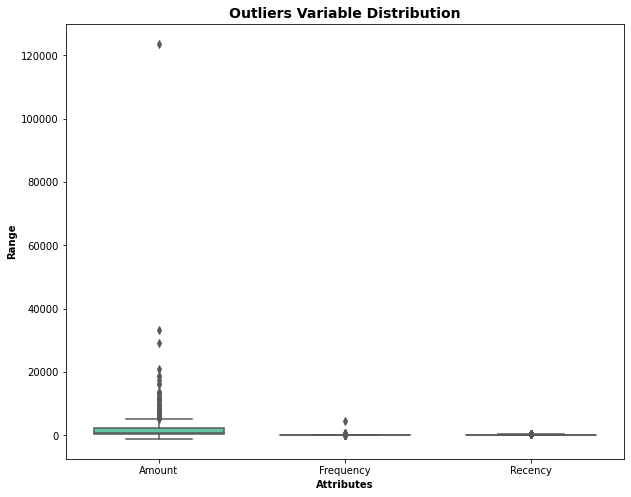

In [ ]:
# Outlier Analysis of Amount Frequency and Recency

attributes = ['Amount','Frequency','Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = rfm[attributes], orient="v", palette="Set2" ,whis=1.5,saturation=1, width=0.7)
plt.title("Outliers Variable Distribution", fontsize = 14, fontweight = 'bold')
plt.ylabel("Range", fontweight = 'bold')
plt.xlabel("Attributes", fontweight = 'bold')

In [ ]:
# Removing (statistical) outliers for Amount
Q1 = rfm.Amount.quantile(0.25)
Q3 = rfm.Amount.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Amount >= Q1 - 1.5*IQR) & (rfm.Amount <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Recency
Q1 = rfm.Recency.quantile(0.25)
Q3 = rfm.Recency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Recency >= Q1 - 1.5*IQR) & (rfm.Recency <= Q3 + 1.5*IQR)]

# Removing (statistical) outliers for Frequency
Q1 = rfm.Frequency.quantile(0.25)
Q3 = rfm.Frequency.quantile(0.75)
IQR = Q3 - Q1
rfm = rfm[(rfm.Frequency >= Q1 - 1.5*IQR) & (rfm.Frequency <= Q3 + 1.5*IQR)]

In [ ]:
# Rescaling the attributes

rfm_df = rfm[['Amount', 'Frequency', 'Recency']]

# Instantiate
scaler = MinMaxScaler()

# fit_transform
rfm_df_scaled = scaler.fit_transform(rfm_df)
rfm_df_scaled.shape

(424, 3)

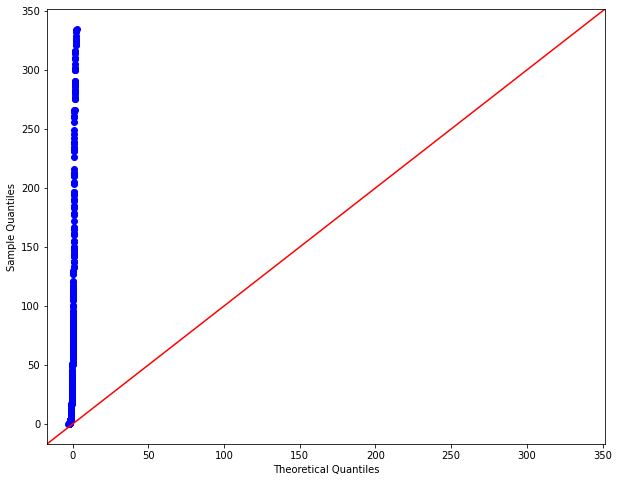

In [ ]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

#create Q-Q plot with 45-degree line added to plot
fig = sm.qqplot(rfm_df["Recency"].array, line='45')
plt.show()


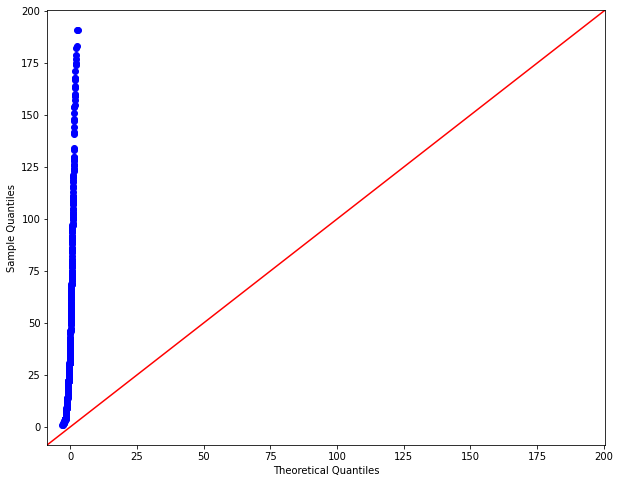

In [ ]:
fig = sm.qqplot(rfm_df["Frequency"].array, line='45')
plt.show()


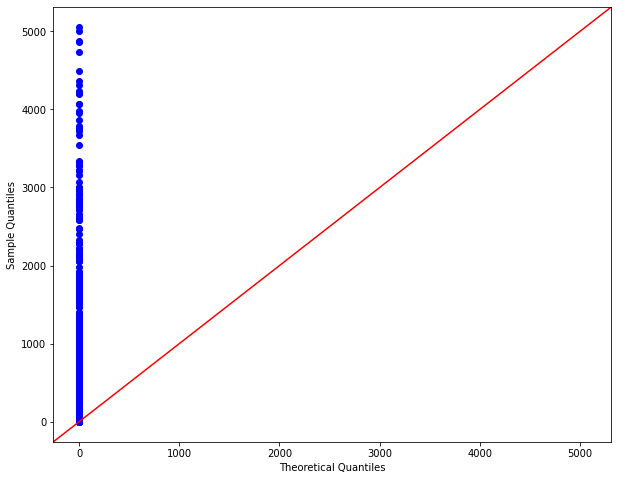

In [ ]:
fig = sm.qqplot(rfm_df["Amount"].array, line='45')
plt.show()


In [ ]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,0.000889,0.005263,0.970149
1,0.852025,0.952632,0.002985
2,0.355806,0.157895,0.220896
3,0.347969,0.378947,0.053731
4,0.066926,0.084211,0.922388


In [ ]:
distance_matrix=cosine_distances(rfm_df_scaled)

In [ ]:
distance_matrix.shape

(424, 424)

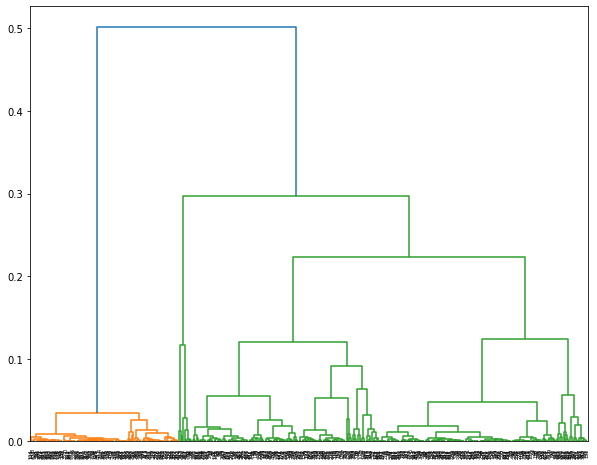

In [ ]:
mergings = linkage(rfm_df_scaled, method="average", metric='cosine')
dendrogram(mergings)
plt.show()

In [ ]:

cluster_labels2 = cut_tree(mergings, n_clusters=2).reshape(-1, )
cluster_labels3 = cut_tree(mergings, n_clusters=3).reshape(-1, )
cluster_labels4 = cut_tree(mergings, n_clusters=4).reshape(-1, )
cluster_labels5 = cut_tree(mergings, n_clusters=5).reshape(-1, )
cluster_labels6 = cut_tree(mergings, n_clusters=6).reshape(-1, )
cluster_labels7 = cut_tree(mergings, n_clusters=7).reshape(-1, )
cluster_labels8 = cut_tree(mergings, n_clusters=8).reshape(-1, )
cluster_labels9 = cut_tree(mergings, n_clusters=9).reshape(-1, )


In [ ]:
all_label_clusters=list([cluster_labels2, cluster_labels3, cluster_labels4, cluster_labels5, cluster_labels6, cluster_labels7, cluster_labels8, cluster_labels9])

In [ ]:
from sklearn.metrics import silhouette_score


# silhhouette1=silhouette_score(distance_matrix, cluster_labels1, metric='precomputed', sample_size=None, random_state=None)
silhhouette2=silhouette_score(distance_matrix, cluster_labels2, metric='precomputed', sample_size=None, random_state=None)
silhhouette3=silhouette_score(distance_matrix, cluster_labels3, metric='precomputed', sample_size=None, random_state=None)
silhhouette4=silhouette_score(distance_matrix, cluster_labels4, metric='precomputed', sample_size=None, random_state=None)
silhhouette5=silhouette_score(distance_matrix, cluster_labels5, metric='precomputed', sample_size=None, random_state=None)
silhhouette6=silhouette_score(distance_matrix, cluster_labels6, metric='precomputed', sample_size=None, random_state=None)
silhhouette7=silhouette_score(distance_matrix, cluster_labels7, metric='precomputed', sample_size=None, random_state=None)
silhhouette8=silhouette_score(distance_matrix, cluster_labels8, metric='precomputed', sample_size=None, random_state=None)
silhhouette9=silhouette_score(distance_matrix, cluster_labels9, metric='precomputed', sample_size=None, random_state=None)

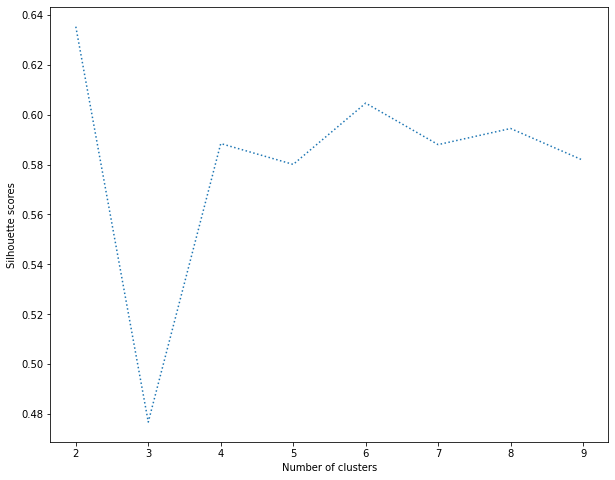

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

ypoints = np.array([silhhouette2, silhhouette3, silhhouette4, silhhouette5, silhhouette6, silhhouette7, silhhouette8, silhhouette9])
plt.xticks([0, 1, 2,3,4,5,6,7], [2, 3, 4, 5, 6, 7, 8, 9],
       rotation=None)  # Set text labels and properties.
plt.plot(ypoints, linestyle = 'dotted')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette scores')
plt.show()

In [ ]:
rfm['mem_average'] = cluster_labels2

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets, linear_model, metrics
from sklearn.linear_model import LinearRegression

In [ ]:

from matplotlib.patches import Polygon


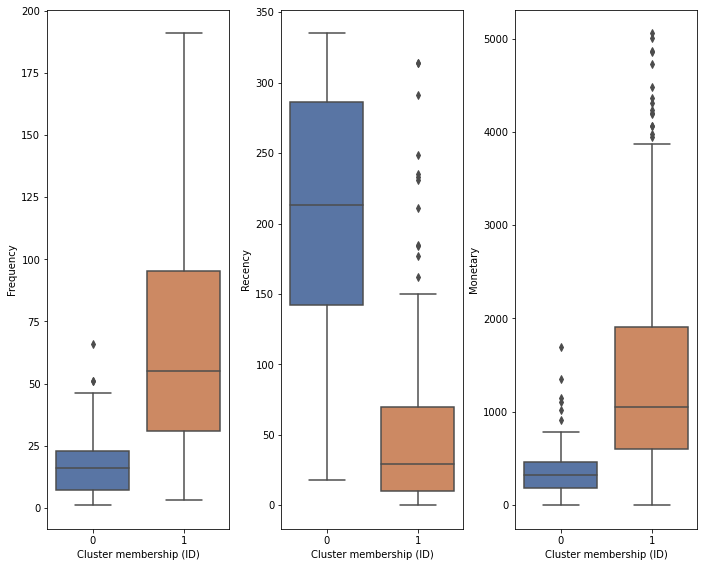

In [ ]:
f, axes = plt.subplots(1, 3)
sns.set(rc={'figure.figsize':(8.5,8.27)})
f.tight_layout(pad=1.5)

sns.boxplot(x='mem_average', y='Frequency', data=rfm, orient='v' , width = 0.8, ax=axes[0]).set(xlabel='Cluster membership (ID)', ylabel='Frequency')
sns.boxplot(x='mem_average', y='Recency', data=rfm, orient='v' , width =0.8, ax=axes[1]).set(xlabel='Cluster membership (ID)', ylabel='Recency')
sns.boxplot(x='mem_average', y='Amount', data=rfm, orient='v' , width = 0.8, linewidth=None,  ax=axes[2]).set(xlabel='Cluster membership (ID)', ylabel='Monetary')
# ax.set_xlabel('xlabel')
plt.show()

In [ ]:
# cluster 1 (compared to cluster 0): 
# higher frequency, more recent purchase (low score of recency), higher amount of money spent 
# => top customers who are likely to respond to campaigns and need more rewards.
# cluster 0 (compared to cluster 1): 
# lower frequency, not having recent purchase (high score of recency), lower amount of money spent 
# => at higher risk of churning, who need customized reactivation campaigns and useful products should be shown to them 


In [ ]:
percen=rfm['mem_average'].value_counts()/len(rfm['mem_average'])*100
print(percen)
percen=percen.tolist()
print(percen)

1    73.349057
0    26.650943
Name: mem_average, dtype: float64
[73.34905660377359, 26.650943396226417]


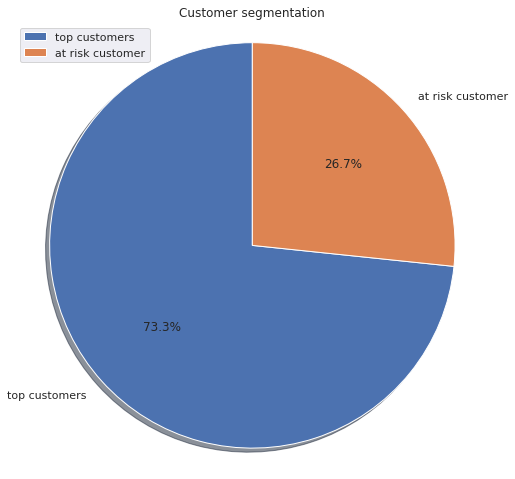

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

y_percen = np.array(percen)
mylabels = ["top customers", 'at risk customer']

# plt.pie(y_percen, labels = mylabels)

plt.pie(y_percen, labels=mylabels, autopct='%1.1f%%', explode=[0,0], shadow=True, startangle=90)
plt.legend()
plt.title('Customer segmentation')
plt.axis('equal')
plt.show()
plt.show() 